# Notebook for Monte-Carlo Simulation

In [2]:
## Import Various Packages 

%load_ext autoreload
%autoreload 2

%load_ext line_profiler
# Import files related to the model
from Simulation import simulate
import EGM
import tools
import DC_EGM
import Estimation as est

# Import General packages 
import numpy as np
from scipy import optimize
from model import Model
from matplotlib import pyplot as plt
import pickle
import seaborn as sns
import auxiliary_funcs as af
import time as time
import copy as copy
import pandas as pd 

import warnings
warnings.filterwarnings('ignore') #:)

In [3]:
# Parameters used 
par2 = {'a_max':100,
        'Smax': 6,
        'sigma_taste': 0.3,
        'sigma': 0.5,
        'm_initial': 1,
        'phi_high': 5,
        'phi_low': 1,
        'theta_high':0.66,
        'theta_low':0.33,
        'lambda_max':0.797
        }

In [4]:
# Set up of the model
model = Model() # Load model
model.setup() # Set initial parameters 

# solution and simulation specs
model.par.Na = 200
model.par.Tmax = 45
model.par.Tsim = model.par.Tmax
model.par.Ntypes = 4
model.par.N = 10000
model.par.Ns = 10
# set parameters to those in par2
for key, val in par2.items():
    model.par.__setattr__(key, val)

model.par.easy_par=False # Not used

# Set grids
model.set_grids()

par = model.par
sol = model.sol
sim = model.sim

In [109]:
# Solve Model 
model.solve()
print("Model Solved")

Model Solved


# 1) Monte Carlo Experiment I 

In [77]:
run = True # Change to True to Run the Experiment

if run == False: 
    # Initialize 
    Results = {}  # Dictionary for results
    dist_true = [0.25,0.25,0.25,0.25] # True parameters 
    N = 50 # Number of MC iterations 

    for i in range(N): 

        par.dist = dist_true # Reset distribution to the true distribution

        est.reset_sim(sim,model) # Allocate simulation grids

        # Change Seed 
        seed_obj = np.random 
        seed_obj.seed(1667+i)
        par.random = seed_obj

        simulate(sim,sol,par) # Simulate 
        
        data = model.sim  # Save simulation results
 
        sec = time.time() # Start timing

        res,_ = est.estimate(est.obj,data,model,[0.2,0.8]) # Estimate from geuss

        time_it = time.time() - sec # Calculate Time

        # Dictionary with results for iteration i
        result = {  "p1" : res.x[0], 
                    "p2" : res.x[1], 
                    "fun" : res.fun, 
                    "Succes" : res.success,
                    "Time" : time_it }
        
        Results[f"result_{i}"] = result # Save results 

In [21]:
results.std()

p1         0.026864
p2         0.026138
fun        0.596626
Succes     0.000000
Time      59.540754
dtype: float64

# 2) Monte Carlo Experiment II 

## 2.1) Monte Carlo  

In [79]:
run = False # Change to True to run

sol_true = copy.deepcopy(sol) # Save Actual Solution

if run == True: 
    # Initialize
    Results = {} # Dictionary for results
    
    # True parameters 
    dist_true = [0.25,0.25,0.25,0.25] 
    phi_high_true = 5

    N = 50 # Number of MC iterations 

    for i in range(N): 

        par.dist = dist_true # Set true distribution

        

        # Set Seed
        seed_obj = np.random
        seed_obj.seed(1687+i)
        par.random = seed_obj 

        setattr(model.par, "phi_high", phi_high_true) # Set true transfers 
        est.reset_sim(sim,model)  # Allocation of simulation grids
        simulate(sim,sol_true,par) # Simulate
        
        data = model.sim # Save simulation

        sec = time.time() # Starting timing

        res = est.estimate_transfer(data,model,[0.2,0.8,3]) # Estimate 

        time_it = time.time() - sec #Calculate time

        # Dictionary for results of iteration i
        result = {  "p1" : res.x[0], 
                    "p2" : res.x[1],
                    "Phi_high" : res.x[2], 
                    "fun" : res.fun, 
                    "Succes" : res.success,
                    "Time" : time_it }
        
        Results[f"result_{i}"] = result # Save results

## 2.1) Play around with the results from Experiment II 

In [88]:
# Export experiment II to Pickle
'''
obj_result = Results 
file_result = open('MC.obj2','wb')
pickle.dump(obj_result,file_result,protocol=pickle.HIGHEST_PROTOCOL)
'''


"\nobj_result = Results \nfile_result = open('MC.obj2','wb')\npickle.dump(obj_result,file_result,protocol=pickle.HIGHEST_PROTOCOL)\n"

In [96]:
# Open results 
file_open = open('MC.obj2','rb')
saved_result = pickle.load(file_open)

In [97]:
# Change to dataframe 
Data_2 = pd.DataFrame(saved_result).T

In [98]:
Data_2.mean() # Find mean

p1            0.492586
p2            0.506192
Phi_high      5.002631
fun           3.384104
Succes        1.000000
Time        940.810290
dtype: float64

In [95]:
Data_2.std() # Find Standard Deviation

p1            0.078224
p2            0.023762
Phi_high      0.471917
fun          12.921332
Succes        0.000000
Time        117.555208
dtype: float64

In [28]:
# Unpack results 
phi_highs = np.empty(50)
p1s = np.empty(50)
p2s = np.empty(50)

for i in range(50): 
    phi_highs[i] = saved_result[f'result_{i}']["Phi_high"]
    p1s[i] = saved_result[f'result_{i}']["p1"]
    p2s[i] = saved_result[f'result_{i}']["p2"]

## 2.3) Make a scatter plot over the estimates of phi high and p1 

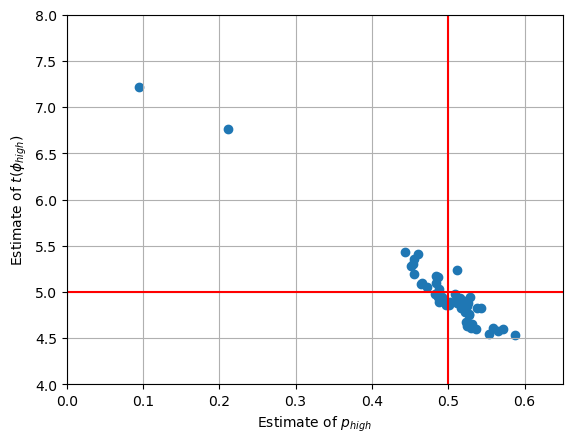

In [100]:
# Make scatter plot that shows the correlation 
fig,ax = plt.subplots(1,1)
ax.scatter(Data_2.p1,Data_2.Phi_high)

ax.set_ylabel("Estimate of $t(\phi_{high})$")
ax.set_xlabel("Estimate of $p_{high}$")
ax.grid()
ax.set_ylim([4,8])
ax.set_xlim([0,0.65])

ax.vlines(0.5,0,10,color="red")
ax.hlines(5,0,10,color="red")

fig.savefig(r"figs\scatter_phi_p_2.png")

In [101]:
# Inspect Outliers 
I = Data_2.fun>6
Data_2[I]

,p1,p2,Phi_high,fun,Succes,Time
result_24,0.211744,0.494812,6.759836,51.70163,True,792.346431
result_28,0.09437,0.434419,7.22307,77.656059,True,643.925917


# 3) Plot Criterion Functions 

## 3.1) Criterion Function for Experiment I 

In [16]:
# Set up of the model
model = Model() # Load model
model.setup() # Set initial parameters 

# solution and simulation specs
model.par.Na = 200
model.par.Tmax = 45
model.par.Tsim = model.par.Tmax
model.par.Ntypes = 4
model.par.N = 10000
model.par.Ns = 10
# set parameters to those in par2
for key, val in par2.items():
    model.par.__setattr__(key, val)

model.par.easy_par=False # Not used

# Set grids
model.set_grids()

par = model.par
sol = model.sol
sim = model.sim

# Simulate and find income shares 
model.solve()
simulate(sim,sol,par)
data = copy.deepcopy(sim)
data_true = data 
share_Rich = np.sum((data_true.type == 0) + (data_true.type == 2)) / len(data_true.type) 
share_Poor = 1-share_Rich


In [14]:
run = True # Change to True to run

if run:
    N = 10 # Points in each dimension

    # Set values 
    p1s = np.linspace(1e-8, 1-1e-8, N)
    p2s = np.linspace(1e-8, 1-1e-8, N)

    criterion = np.zeros((N,N)) # Grid to save values 

    for i1,p1 in enumerate(p1s): # Find criterion value for each point in p1s x p2s 
        for i2,p2 in enumerate(p2s):
            c = est.obj([p1,p2], data, model, [share_Rich, share_Poor], "I")
            criterion[i1,i2] = c

    to_file = (p1s, p2s, criterion) # Make ready to save 

    with open('criterion_plot_10000','wb') as file: # Save File 
        pickle.dump(to_file, file)

NameError: name 'share_Rich' is not defined

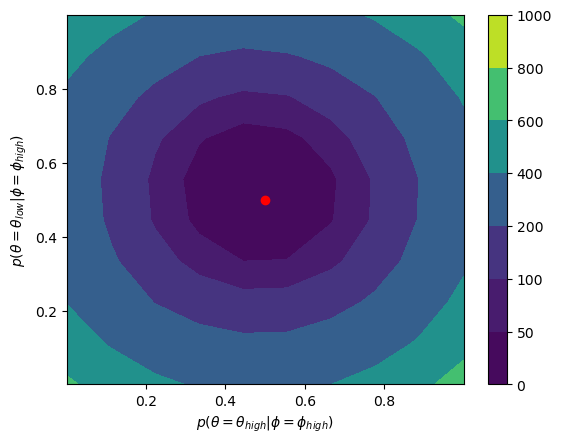

In [141]:
# Plot the criterion function using the values from above
%matplotlib inline

with open('criterion_plot_10000', 'rb') as file:
    p1s, p2s, criterion = pickle.load(file)

p1_mesh, p2_mesh = np.meshgrid(p1s, p2s,  indexing='ij')

fig = plt.figure()
ax = fig.add_subplot()
contour = ax.contourf(p1_mesh, p2_mesh, criterion, cmap='viridis', levels = [0,50, 100, 200, 400, 600, 800, 1000])
ax.set_xlabel(r'$p(\theta = \theta_{high} | \phi = \phi_{high})$')
ax.set_ylabel(r'$p(\theta = \theta_{low} | \phi = \phi_{high})$')
ax.scatter(0.5, 0.5, color='red')

cbar = fig.colorbar(contour)

fig.savefig('figs/criterion_p1p2.png')

## 3.2) Criterion functions for Experiment II 

In [17]:
model_easy = Model()
model_easy.setup()

# solution and simulation specs
model_easy.par.Na = 200
model_easy.par.Tmax = 45
model_easy.par.Tsim = model.par.Tmax
model_easy.par.Ntypes = 4
model_easy.par.N = 10000

# set parameters
for key, val in par2.items():
    model_easy.par.__setattr__(key, val)

model_easy.par.easy_par = False
model_easy.set_grids()

print('Setup done')

model_easy.solve()
print('Model solved')

simulate(model_easy.sim, model_easy.sol, model_easy.par)
print('Model simulated')



Setup done
Model solved
Model simulated


In [18]:
data_easy = copy.deepcopy(model_easy.sim)

In [19]:
# Criterion function, fix p2=0.5
# tranfsers and p1
run = True

if run:
    p2 = 0.5
    N = 10
    p1_grid = np.linspace(1e-8, 1-1e-8, N)
    phi_grid = np.linspace(2, 8, N)
    p1_mesh, phi_mesh = np.meshgrid(p1_grid, phi_grid, indexing='ij')

    cri1_mesh = np.zeros((N,N)) + np.nan

    for i1,p1 in enumerate(p1_grid):
        for ip,phi in enumerate(phi_grid):
            c = est.obj_transfer([p1,p2, phi], data_easy, model_easy, [share_Rich, share_Poor], "I")
            cri1_mesh[i1,ip] = c

    to_file = (p1_grid, phi_grid, cri1_mesh)

    with open('criterion_plot_p1phi','wb') as file:
        pickle.dump(to_file, file)

5105.380673077476
2927.315627552893
1602.9981712807682
865.0077963503521
421.6138549625449
178.75258062696795
53.77550082896774
9.846275001638595
24.829643236441697
76.26697588070685
4450.353244462103
2388.908048146858
1229.3324690945879
619.1754119672897
269.35978183679975
93.75528634169727
17.926286163427307
9.558549903925762
49.27410140570591
118.50598046943661
3863.378560843589
1895.093150338766
902.075303952725
412.7143882897161
149.4566941513782
34.79385530036952
2.8780541602144103
27.834092484631014
91.28452176560674
177.24194090892394
3354.8620221720603
1480.086366813924
637.2537926347388
254.7284794797563
67.2969460264173
5.897439772618772
10.433260232231811
61.34559462586779
141.81976395810426
239.52540521202792
2901.618044470528
1114.0594409328628
418.5687196430651
131.69377268899447
17.772933656414782
3.6085513740481274
41.54351151856668
117.02144597915378
213.3550696053212
320.2301896346154
2519.3056091368417
813.3403594153148
247.10486567927387
51.7121039593696
1.01955151

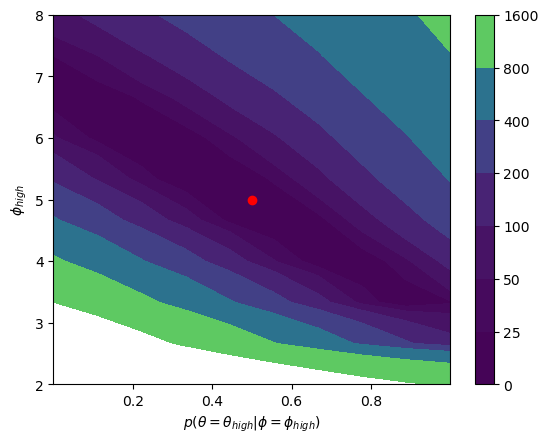

In [20]:
%matplotlib inline

with open('criterion_plot_p1phi', 'rb') as file:
    p1s, phi_grid, cri1_mesh = pickle.load(file)

p1_mesh, phi_mesh = np.meshgrid(p1s, phi_grid, indexing='ij')

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
contour = ax.contourf(p1_mesh, phi_mesh, cri1_mesh, levels=[0, 25, 50, 100, 200, 400, 800, 1600])
ax.set_xlabel(r'$p(\theta = \theta_{high} | \phi = \phi_{high})$')
ax.set_ylabel('$\phi_{high}$')

cmap = fig.colorbar(contour)

ax.scatter(0.5, 5, label='True value', color='red')

fig.savefig('figs/criterion_p1phi.png')

In [21]:
# Criterion function, fix p1=0.5
# transfers and p2

run = True

if run:
    p1 = 0.5
    N = 10
    p2_grid = np.linspace(1e-8, 1-1e-8, N)
    phi_grid = np.linspace(2, 8, N)
    p2_mesh, phi_mesh = np.meshgrid(p1_grid, phi_grid, indexing='ij')

    cri2_mesh = np.zeros((N,N)) + np.nan

    for i2,p2 in enumerate(p1_grid):
        for ip,phi in enumerate(phi_grid):
            c = est.obj_transfer([p1,p2, phi], data, model, [share_Rich, share_Poor], "I")
            cri2_mesh[i2,ip] = c

    to_file = (p2_grid, phi_grid, cri2_mesh)

    with open('criterion_plot_p2phi','wb') as file:
        pickle.dump(to_file, file)

3056.901966945079
1309.9149211431145
679.1614423917426
439.6804501803078
361.5007283780331
368.8935563816686
422.6703741815518
508.89205749575865
612.4994782897311
724.7043580722589
2922.977158148188
1176.657424174602
545.06574379413
305.7115517417878
228.0885629846381
235.63200503528856
288.4150776140782
374.40113065832145
476.78114053237607
588.7340147299724
2824.472397389531
1069.8003808823044
444.31204605192977
205.33748798688288
127.61336047466824
134.5119334444713
186.79027754933537
272.97883114938855
375.46055608171355
487.0414054425497
2761.005997415853
1003.5583515644598
373.7548176621815
133.1786235978596
53.274682336870654
58.56148413044698
109.15300422927919
193.97330322740788
295.6806458172865
408.14440022141844
2715.890156431249
964.3097850524123
332.6254034787331
93.09119216660761
13.605999940274923
19.499862867807664
72.17128453344792
157.96048765162362
257.8349283325377
368.51222152930757
2706.8251311943495
957.7594068755747
326.9131589366863
86.8431555355434
7.2369744

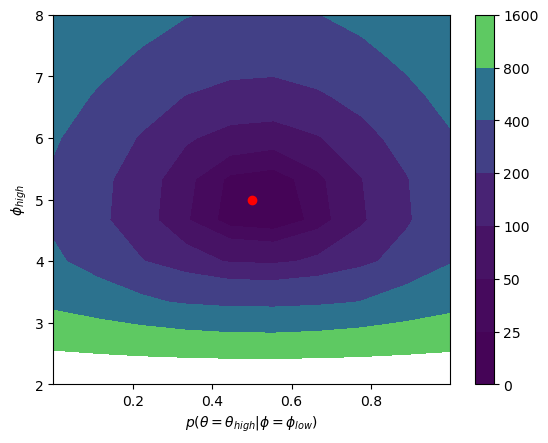

In [23]:
%matplotlib inline

with open('criterion_plot_p2phi', 'rb') as file:
    p2s, phi_grid, cri2_mesh = pickle.load(file)

p2_mesh, phi_mesh = np.meshgrid(p2s, phi_grid, indexing='ij')

fig = plt.figure()
ax = fig.add_subplot()
contour = ax.contourf(p2_mesh, phi_mesh, cri2_mesh, cmap='viridis', levels=[0, 25, 50, 100, 200, 400, 800, 1600])
ax.set_xlabel(r'$p(\theta = \theta_{high} | \phi = \phi_{low})$')
ax.set_ylabel('$\phi_{high}$')

cmap = fig.colorbar(contour)

ax.scatter(0.5, 5, color='red')

fig.savefig('figs/criterion_p2phi.png')